In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [2]:
np.random.seed(42) 

In [3]:
iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data['species'] = iris.target
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
X = iris.data
y = iris.target

# data splitting
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2,random_state=42)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test  = scaler.transform(X_test)      

In [6]:
# number of classes (iris has 3 species: 0,1,2)
num_classes = len(np.unique(y))
# X has shape (num_samples, num_features)
num_samples, num_features = X.shape
input_size = num_features

In [7]:
# one-hot in data processing
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh  = np.eye(num_classes)[y_test]

In [8]:
# Activation functions
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)
    
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)
    
def softmax(z):
    # stability trick
    z = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [9]:
class NeuralNet:
  
    def __init__(self, sizes, learning_rate=0.01, keep_prob=1.0, l2_lambda=0.0):
        
        self.lr = learning_rate
        self.keep_prob = keep_prob
        self.l2_lambda = l2_lambda
        
        self.W = []
        self.b = []

        # # Simple random initialization 
        # for i in range(len(sizes) - 1):
        #     self.W.append(np.random.randn(sizes[i], sizes[i+1]) * 0.01)
        #     self.b.append(np.zeros((1, sizes[i+1])))


        # He initialization for ReLU
        for i in range(len(sizes) - 1):
            fan_in = sizes[i]
            self.W.append(np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2.0 / fan_in))
            self.b.append(np.zeros((1, sizes[i+1])))

            
    
    # Forward pass
    def forward(self, X, training=True):
        
        A = X
        
        # store (A_prev, Z, A, mask) for each layer
        self.cache = []
        self.training = training 

        for i in range(len(self.W)):

            A_prev = A
            Z = A_prev @ self.W[i] + self.b[i]

            # hidden layers: ReLU
            if i < len(self.W) - 1:
                A = relu(Z)


                # inverted dropout (training only)
                if training and self.keep_prob < 1.0:                       
                    mask = (np.random.rand(*A.shape) < self.keep_prob).astype(float) 
                    # scale activation
                    A = (A * mask) / self.keep_prob                        
                else:
                    mask = None 
                    

                
            # last layer: Softmax
            else:
                A = softmax(Z)
                # output layer has no dropout
                mask = None   

            self.cache.append((A_prev, Z, A, mask)) 

        return A

        
    # Loss function
    def compute_loss(self, y_pred, y_true, include_l2=True):
    
        # number of samples
        m = y_true.shape[0]

        # add small epsilon to avoid log(0)
        eps = 1e-12
        base_loss = -np.sum(y_true * np.log(y_pred + eps)) / m

        
        if not include_l2:
            return base_loss


        # L2 regularization (weight decay): penalize large weights
        l2_loss = 0.0
        for W in self.W:
            l2_loss += np.sum(W * W)
        l2_loss = (self.l2_lambda / (2 * m)) * l2_loss

        
        return base_loss + l2_loss
        
        
    # Backward pass
    def backward(self, y_true):

        # number of samples
        m = y_true.shape[0]

        # last layer index
        L = len(self.W) - 1  

        # Output layer gradient
        _, _, AL, _ = self.cache[L]

        dZ = (AL - y_true) / m

        for i in reversed(range(len(self.W))):

            # get cache for layer i
            A_prev, _, _, _ = self.cache[i]

            # L2 regularization gradient (weight decay)
            l2_grad = (self.l2_lambda / m) * self.W[i]
            
            # compute gradients dW, db
            dW = A_prev.T @ dZ

            dW += l2_grad
            
            db = np.sum(dZ, axis=0, keepdims=True)
            
            # propagate to previous layer (if not input layer)
            if i > 0:

                # Z_prev for ReLU derivative, mask_prev for dropout backward
                _, Z_prev, _, mask_prev = self.cache[i-1]
                
                dZ_prev = dZ @ self.W[i].T 

                # inverted dropout backward (training only)
                if mask_prev is not None:   
                    # scale gradient
                    dZ_prev = (dZ_prev * mask_prev) / self.keep_prob

                # ReLU backprop
                dZ_prev = dZ_prev * relu_derivative(Z_prev) 
                
                # update dZ
                dZ = dZ_prev
            
            # parameter update for layer i
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    
    # Prediction
    def predict(self, X):
        probs = self.forward(X, training=False) 
        return np.argmax(probs, axis=1)

In [10]:
hidden_sizes = [10, 6] 
learning_rate = 0.05
num_epochs = 1000
keep_prob=0.8
l2_lambda = 0.1


# define architecture by a list
sizes = [input_size] + hidden_sizes + [num_classes]
# initialize neural network
nn = NeuralNet(sizes=sizes, learning_rate=learning_rate, keep_prob=keep_prob, l2_lambda=l2_lambda)






# record history
log_records = []




for epoch in range(num_epochs):

    # ===== Training step (with dropout) =====
    
    train_probs_trainmode = nn.forward(X_train, training=True) 

    # train loss
    train_base_loss = nn.compute_loss(train_probs_trainmode, y_train_oh, include_l2=False)
    train_total_loss = nn.compute_loss(train_probs_trainmode, y_train_oh, include_l2=True)
    
    # update parameters
    nn.backward(y_train_oh)


    # ===== Evaluation step (no dropout) =====
    if (epoch + 1) % 100 == 0:


        # forward without dropout
        train_probs_evalmode = nn.forward(X_train, training=False)
        test_probs_evalmode  = nn.forward(X_test,  training=False)

        # accuracy comparison
        train_acc = np.mean(np.argmax(train_probs_evalmode, axis=1) == y_train)
        test_acc  = np.mean(np.argmax(test_probs_evalmode,  axis=1) == y_test)
        
        # loss comparison
        train_eval_loss = nn.compute_loss(train_probs_evalmode, y_train_oh, include_l2=False)
        test_eval_loss  = nn.compute_loss(test_probs_evalmode,  y_test_oh,  include_l2=False)



        # ===== record history =====                            
        log_records.append({
            "epoch": epoch + 1,
            "train_base_loss(train)": train_base_loss,
            "train_total_loss(train)": train_total_loss,
            "train_loss(eval)": train_eval_loss,
            "test_loss(eval)": test_eval_loss,
            "train_acc(eval)": train_acc,
            "test_acc(eval)": test_acc,
        })

        
        print(
            f"Epoch {epoch+1:4d} | "
            f"train_total_loss: {train_total_loss:.4f} | "
            f"train_acc(eval): {train_acc:.4f} | "
            f"test_acc(eval): {test_acc:.4f}"
        )


Epoch  100 | train_total_loss: 0.5412 | train_acc(eval): 0.9083 | test_acc(eval): 0.9000
Epoch  200 | train_total_loss: 0.4645 | train_acc(eval): 0.9667 | test_acc(eval): 0.9667
Epoch  300 | train_total_loss: 0.4063 | train_acc(eval): 0.9750 | test_acc(eval): 1.0000
Epoch  400 | train_total_loss: 0.4078 | train_acc(eval): 0.9583 | test_acc(eval): 1.0000
Epoch  500 | train_total_loss: 0.3574 | train_acc(eval): 0.9667 | test_acc(eval): 1.0000
Epoch  600 | train_total_loss: 0.3387 | train_acc(eval): 0.9667 | test_acc(eval): 1.0000
Epoch  700 | train_total_loss: 0.3084 | train_acc(eval): 0.9667 | test_acc(eval): 1.0000
Epoch  800 | train_total_loss: 0.3413 | train_acc(eval): 0.9667 | test_acc(eval): 1.0000
Epoch  900 | train_total_loss: 0.3134 | train_acc(eval): 0.9667 | test_acc(eval): 1.0000
Epoch 1000 | train_total_loss: 0.2682 | train_acc(eval): 0.9667 | test_acc(eval): 1.0000


In [11]:
df = pd.DataFrame(log_records)
df

,epoch,train_base_loss(train),train_total_loss(train),train_loss(eval),test_loss(eval),train_acc(eval),test_acc(eval)
0,100,0.526195,0.541203,0.449892,0.426459,0.908333,0.900000
1,200,0.448687,0.464543,0.338050,0.311473,0.966667,0.966667
2,300,0.389933,0.406331,0.282969,0.247392,0.975000,1.000000
3,400,0.390983,0.407847,0.240887,0.201075,0.958333,1.000000
4,500,0.340121,0.357359,0.210268,0.169112,0.966667,1.000000
5,600,0.321182,0.338722,0.189489,0.149689,0.966667,1.000000
6,700,0.290572,0.308410,0.170257,0.130755,0.966667,1.000000
7,800,0.323175,0.341297,0.156534,0.118952,0.966667,1.000000
8,900,0.295103,0.313445,0.143806,0.106274,0.966667,1.000000
9,1000,0.249639,0.268221,0.133377,0.098316,0.966667,1.000000


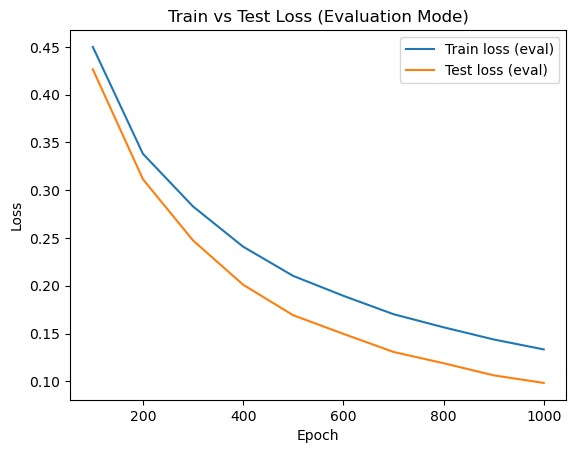

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["epoch"], df["train_loss(eval)"], label="Train loss (eval)")
plt.plot(df["epoch"], df["test_loss(eval)"], label="Test loss (eval)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss (Evaluation Mode)")
plt.legend()
plt.show()


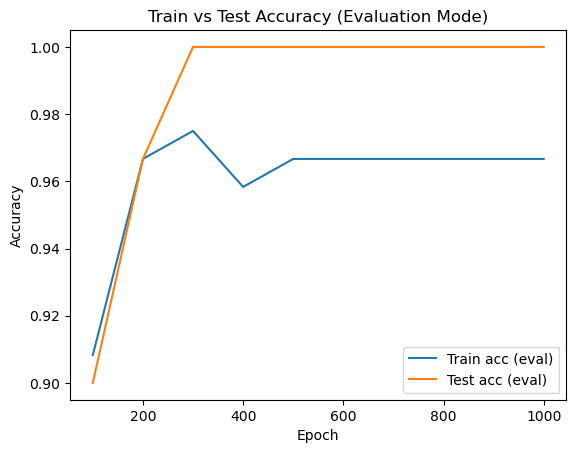

In [13]:
plt.figure()
plt.plot(df["epoch"], df["train_acc(eval)"], label="Train acc (eval)")
plt.plot(df["epoch"], df["test_acc(eval)"], label="Test acc (eval)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy (Evaluation Mode)")
plt.legend()
plt.show()


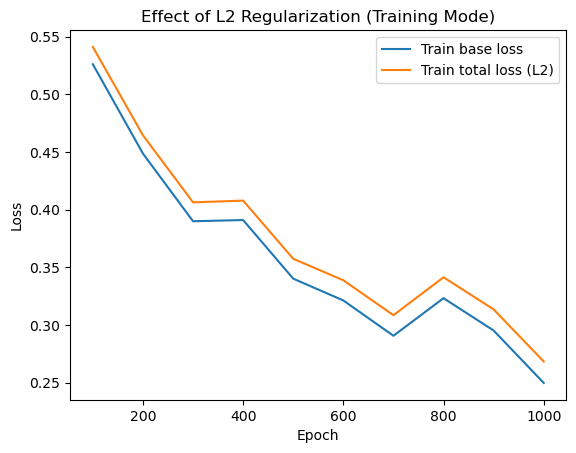

In [14]:
plt.figure()
plt.plot(df["epoch"], df["train_base_loss(train)"], label="Train base loss")
plt.plot(df["epoch"], df["train_total_loss(train)"], label="Train total loss (L2)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Effect of L2 Regularization (Training Mode)")
plt.legend()
plt.show()
